In [1]:
#Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, auc, precision_recall_curve, confusion_matrix
import seaborn as sns
import os
import snowflake.connector
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB

In [2]:
conn = snowflake.connector.connect(
    user=os.getenv('USERNAME_2'),
    password=os.getenv('SNOWSQL_PWD'),
    account=os.getenv('ACCOUNT_NAME'),
    database=os.getenv('DATABASE'),
    schema=os.getenv('SCHEMA'),
    warehouse=os.getenv('WAREHOUSE'),
    login_timeout=60,
    client_session_keep_alive=True
)

In [3]:
cursor = conn.cursor()
query = """Select msg.is_opened, msg.message_type, msg.channel, msg.subject_with_bonuses, msg.subject_with_deadline, msg.subject_with_discount, msg.subject_with_emoji, msg.subject_with_saleout, msg.subject_length, msg.sent_at
from message_extended as msg
where msg.subject_with_discount is not null;"""
cursor.execute(query)
result = cursor.fetchall()

In [4]:
messages_df = pd.DataFrame(result, columns=[col[0] for col in cursor.description])

In [5]:
cursor.close()
conn.close()
del result, cursor, conn

In [6]:
messages_df['SENT_AT'] = pd.to_datetime(messages_df['SENT_AT'])

In [7]:
messages_df['Hour'] = messages_df['SENT_AT'].dt.hour

In [8]:
def time_periods(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    else:
        return 'Evening'
#Apply the custom function to the 'hour' column and create a new 'period' column
messages_df['TimePeriod'] = messages_df['Hour'].apply(time_periods)

In [9]:
def convert_to_bool(value):
    if  value.lower() == 't' or value.lower() == 'true':
        return 1
    elif  value.lower() == 'f' or value.lower() == 'false':
        return 0
    return value

In [10]:
#Changing datatypes of mesages dataset (messages_df) attributes
messages_df['IS_OPENED'] = messages_df['IS_OPENED'].apply(convert_to_bool)
messages_df['SUBJECT_WITH_BONUSES'] = messages_df['SUBJECT_WITH_BONUSES'].apply(convert_to_bool)
messages_df['SUBJECT_WITH_DEADLINE'] = messages_df['SUBJECT_WITH_DEADLINE'].apply(convert_to_bool)
messages_df['SUBJECT_WITH_DISCOUNT'] = messages_df['SUBJECT_WITH_DISCOUNT'].apply(convert_to_bool)
messages_df['SUBJECT_WITH_EMOJI'] = messages_df['SUBJECT_WITH_EMOJI'].apply(convert_to_bool)
messages_df['SUBJECT_WITH_SALEOUT'] = messages_df['SUBJECT_WITH_SALEOUT'].apply(convert_to_bool)

In [11]:
#========================Converting the 'message_type' values into dummy variables=================
final_message_df = pd.get_dummies(messages_df, columns=['MESSAGE_TYPE','CHANNEL','TimePeriod'])

In [12]:
def convert_to_int(value):
    if value is True:
        return 1
    else:
        return 0

In [13]:
final_message_df['TimePeriod_Afternoon'] = final_message_df['TimePeriod_Afternoon'].apply(convert_to_int)
final_message_df['TimePeriod_Evening'] = final_message_df['TimePeriod_Evening'].apply(convert_to_int)
final_message_df['TimePeriod_Morning'] = final_message_df['TimePeriod_Morning'].apply(convert_to_int)
final_message_df['TimePeriod_Night'] = final_message_df['TimePeriod_Night'].apply(convert_to_int)

In [14]:
del messages_df

In [15]:
final_message_df.dropna(inplace=True)

In [16]:
columns = ['SENT_AT', 'Hour', 'CHANNEL_mobile_push']

In [17]:
final_message_df.drop(columns=columns, inplace=True)

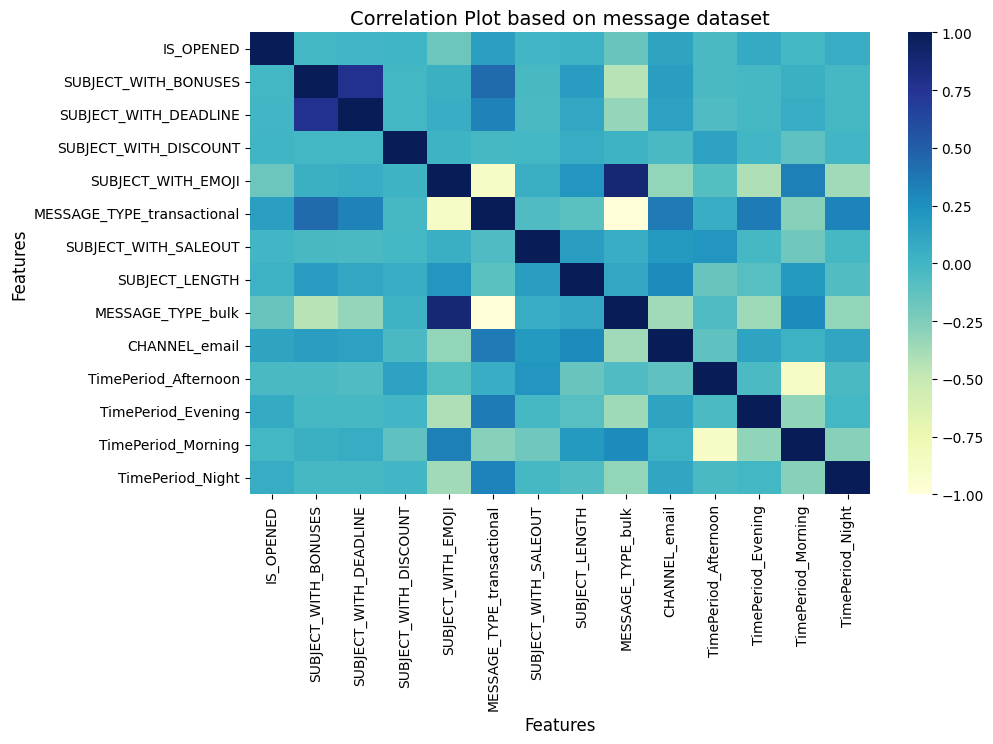

In [18]:
columns = ['IS_OPENED', 'SUBJECT_WITH_BONUSES',
       'SUBJECT_WITH_DEADLINE', 'SUBJECT_WITH_DISCOUNT', 'SUBJECT_WITH_EMOJI','MESSAGE_TYPE_transactional',
       'SUBJECT_WITH_SALEOUT', 'SUBJECT_LENGTH', 'MESSAGE_TYPE_bulk',
       'CHANNEL_email', 'TimePeriod_Afternoon', 'TimePeriod_Evening',
       'TimePeriod_Morning', 'TimePeriod_Night']

correlation_matrix = final_message_df[columns].corr()
# Create a correlation plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.heatmap(correlation_matrix, cmap='YlGnBu')
# Add plot title and adjust font size
plt.title('Correlation Plot based on message dataset', fontsize=14)
# Set the font size of the axis labels
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
# Show the plot
plt.show()

In [19]:
accuracies = []
columns = ['SUBJECT_LENGTH','TimePeriod_Evening', 'TimePeriod_Night']

X = final_message_df[columns]

#Using 'message_type_in_numerical_form' as a target variable
y = final_message_df['IS_OPENED']

#Define the list of X (Independent Variable features)
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train, X_, y_train, y_ = train_test_split(X_t, y_t, train_size=0.001, random_state=42, stratify = y_t)

### SMOTE

In [20]:
#==================Applying SMOTE for Oversampling=====================
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [21]:
###==========================Light GBM after SMOTE===================================
train_data = lgb.Dataset(X_train_smote, label=y_train_smote)
# Defining the LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'lambda_l2': 0.1,  # Ridge Regularization
    'num_leaves': 31,
    'learning_rate': 0.5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}
# Training the LightGBM model
model = lgb.train(params, train_data, num_boost_round=100)
# Making predictions on the testing data
y_pred_lgb = model.predict(X_test)
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_lgb]
# Evaluating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_binary)
accuracies.append(['Light GBM', accuracy])
print("Accuracy for Light GBM:", accuracy)

Accuracy for Light GBM: 0.7184960319126067


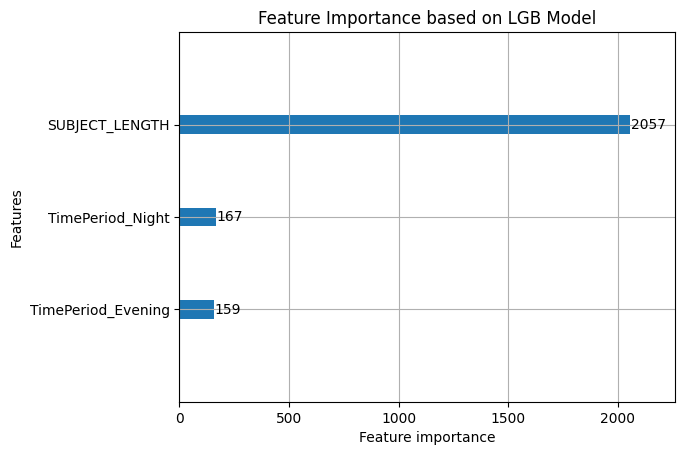

In [22]:
#===========================Feature Importance Graph based on Light GBM==================================
lgb.plot_importance(model, max_num_features=3)
plt.title('Feature Importance based on LGB Model')
plt.show()
#========================================================================================================

In [23]:
#=======================Classification Report based on LGB after applying SMOTE===================
report_lgb = classification_report(y_test, y_pred_binary)
print(report_lgb)
#=================================================================================================

              precision    recall  f1-score   support

           0       0.88      0.77      0.82   1322958
           1       0.27      0.46      0.34    249336

    accuracy                           0.72   1572294
   macro avg       0.58      0.61      0.58   1572294
weighted avg       0.79      0.72      0.75   1572294



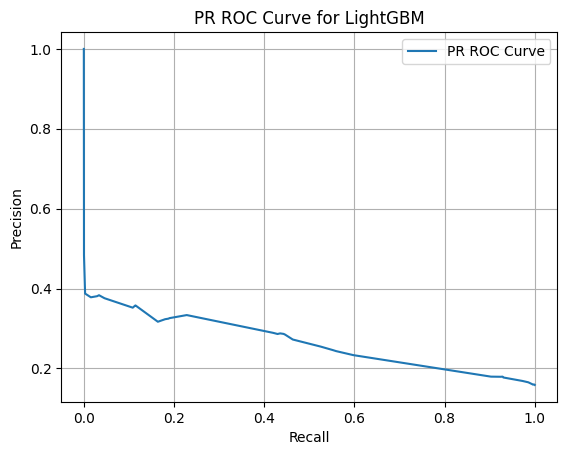

In [24]:
#============================PR ROC Curve for lightGBM model=============================================
y_prob = y_pred_lgb
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, label='PR ROC Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR ROC Curve for LightGBM')
plt.legend()
plt.grid()
plt.show()
#=======================================================================================================

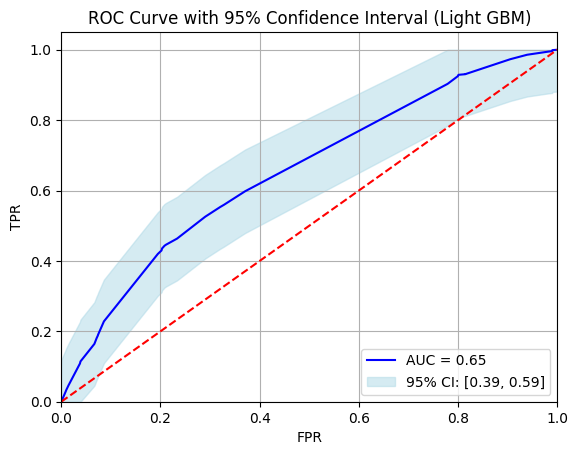

In [25]:
#============================ROC Curve for lightGBM model=============================================
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb)
roc_auc = auc(fpr, tpr)

std_err = np.std(tpr)/np.sqrt(len(tpr))

# Confidence interval
confidence_level = 0.95
z_score = 1.96  # Z socre for 95% confidence interval
upper_bound = np.minimum(tpr + std_err * z_score,1)
lower_bound = np.maximum(tpr - std_err * z_score,0)
# Plot the ROC curve with confidence interval
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,
                 label=f'95% CI: [{lower_bound.mean():.2f}, {upper_bound.mean():.2f}]')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with 95% Confidence Interval (Light GBM)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

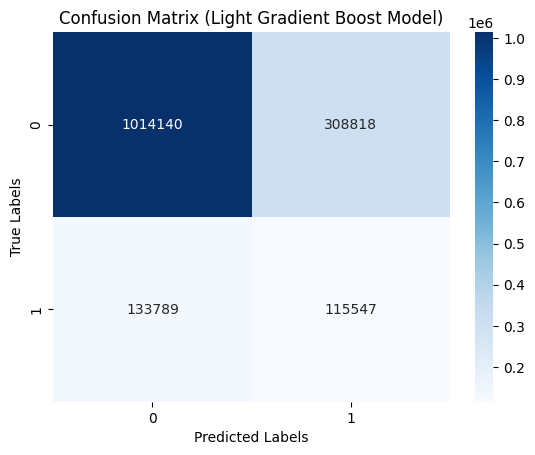

In [26]:
#===============================Confusion Matrix LGB=======================
cm = confusion_matrix(y_test, y_pred_binary)
# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix (Light Gradient Boost Model)')
plt.show()
#=========================================================================

## Random Forest

In [27]:
#==========================Random Forest Model after applying SMOTE========================
clf_RF = RandomForestClassifier(n_estimators = 100, max_depth = 10,  min_samples_split = 10)
clf_RF.fit(X_train_smote, y_train_smote)
# Making predictions on the testing data
y_pred_RF = clf_RF.predict(X_test)
# Evaluating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_RF)
# Calculate the execution time
print(f'Accuracy score(Random Forest Model): {accuracy}')
#==========================================================================================

Accuracy score(Random Forest Model): 0.7181703930689808


In [28]:
#=========================Hyper-parameter Tuning of Random Forest=========================================
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(estimator=clf_RF, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)
best_params = grid_search.best_params_
#==========================================================================================================

In [29]:
#==========================Random Forest Model after applying Hyper Tuning========================
clf_RF = RandomForestClassifier(n_estimators = best_params['n_estimators'], max_depth = best_params['max_depth'],  min_samples_split = best_params['min_samples_split'])
clf_RF.fit(X_train_smote, y_train_smote)
# Making predictions on the testing data
y_pred_RF = clf_RF.predict(X_test)
# Evaluating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_RF)
accuracies.append(['Random Forest', accuracy])
print(f'Accuracy score(Random Forest Model): {accuracy}')
#==========================================================================================

Accuracy score(Random Forest Model): 0.7181703930689808


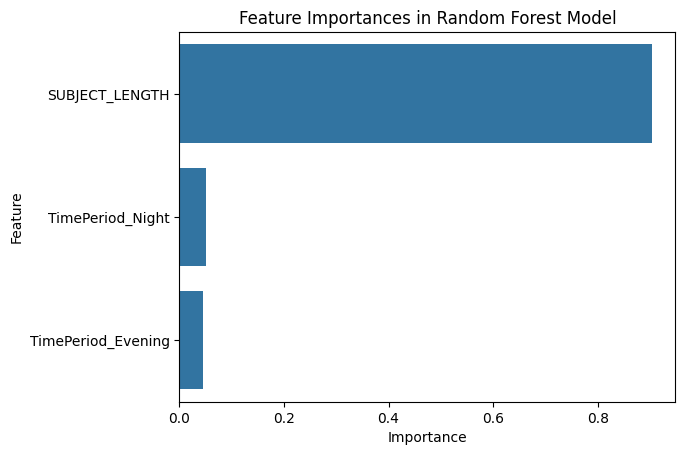

In [30]:
#=========================Feature Importance for Random Forest=======================
feature_importances = clf_RF.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importances in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
#=======================================================================================

In [31]:
#=======================Random Forest Classification Report============================
report_rf = classification_report(y_test, y_pred_RF)
print(report_rf)
#======================================================================================

              precision    recall  f1-score   support

           0       0.88      0.77      0.82   1322958
           1       0.27      0.47      0.34    249336

    accuracy                           0.72   1572294
   macro avg       0.58      0.62      0.58   1572294
weighted avg       0.79      0.72      0.74   1572294



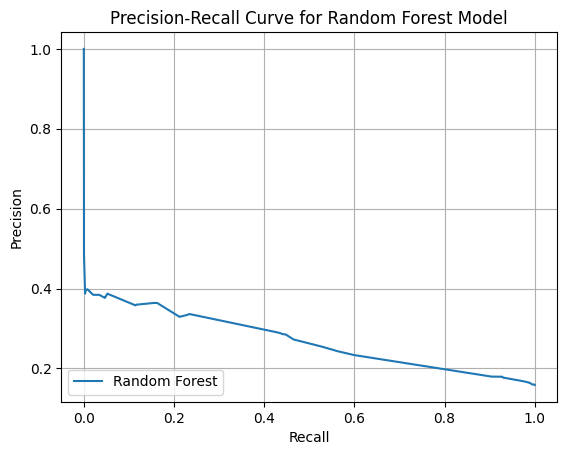

In [32]:
#================================PR ROC Curve for Random Forest Model======================
y_pred_prob = clf_RF.predict_proba(X_test)[:, 1]
precision_dt ,recall_dt, thresholds_dt = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall_dt, precision_dt, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest Model')
plt.legend(loc='lower left')
plt.grid()
plt.show()
#==============================================================================================

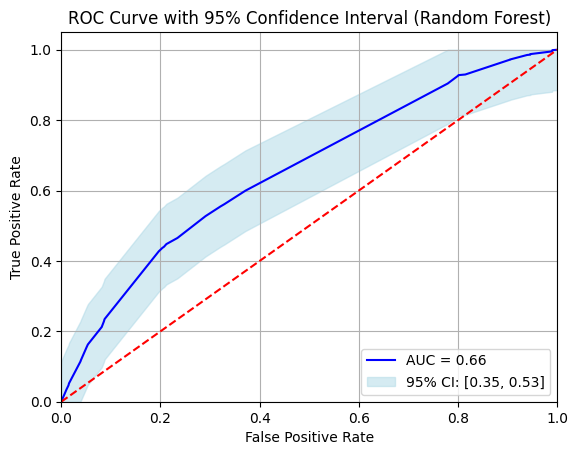

In [33]:
#===============================ROC Curve for Random Forest===============================================
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

std_err = np.std(tpr)/np.sqrt(len(tpr))

# Confidence interval
confidence_level = 0.95
z_score = 1.96  # Z socre for 95% confidence interval
upper_bound = np.minimum(tpr + std_err * z_score,1)
lower_bound = np.maximum(tpr - std_err * z_score,0)
# Plot the ROC curve with confidence interval
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,
                 label=f'95% CI: [{lower_bound.mean():.2f}, {upper_bound.mean():.2f}]')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with 95% Confidence Interval (Random Forest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

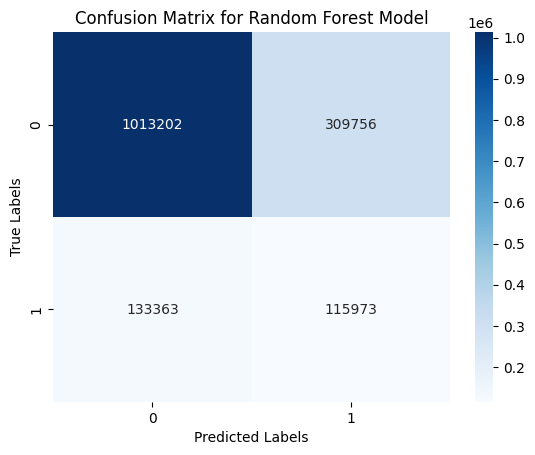

In [34]:
#============================Confusion Matrix for Random Forest model===============================
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_RF)
# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()
#===================================================================================================

## Naive Bayes

In [59]:
#==========================Gaussian Naive Bayes Classifier Model after applying SMOTE========================
# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier with the training data
nb_classifier.fit(X_train_smote, y_train_smote)

# Predict the labels for the test set
y_pred = nb_classifier.predict(X_test)

# Evaluating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy score(Naive Bayes Machine Model): {accuracy}')
#==============================================================================================================N=============

Accuracy score(Naive Bayes Machine Model): 0.835935900028875


In [60]:
#================================================Hyperparameter Tuning of Naive Bayes Classifier=========================
# Define the hyperparameter grid to search
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]  # Different values of var_smoothing to test
}
# Set up Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=0)

# Fit Grid Search to the training data
grid_search.fit(X_train_smote, y_train_smote)

# Get the best parameters from Grid Search
best_params = grid_search.best_params_
#===========================================================================================================================

In [61]:
best_nb_classifier = grid_search.best_estimator_
# Predict the labels for the test set
y_pred = best_nb_classifier.predict(X_test)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
accuracies.append(['Naive Bayes Classifier', accuracy])
print(f'Accuracy: {accuracy}')

Accuracy: 0.5832770461504019


In [62]:
#=======================Naive Bayes Classification Report===========================
print(classification_report(y_test, y_pred))
#===================================================================================

              precision    recall  f1-score   support

           0       0.86      0.60      0.71   1322958
           1       0.18      0.48      0.27    249336

    accuracy                           0.58   1572294
   macro avg       0.52      0.54      0.49   1572294
weighted avg       0.75      0.58      0.64   1572294



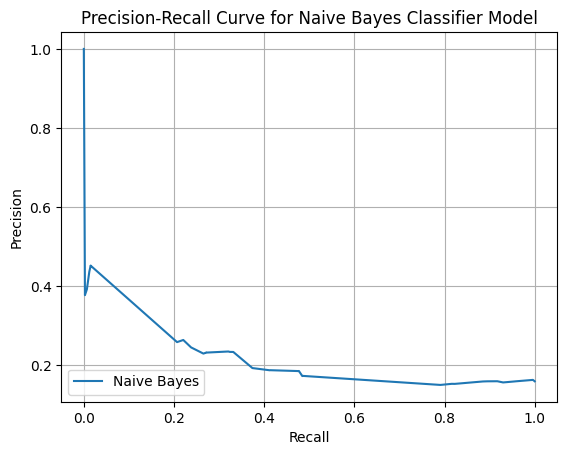

In [63]:
#================================PR ROC Curve for Naive Bayes Model======================
y_proba = best_nb_classifier.predict_proba(X_test)[:, 1]
precision_dt ,recall_dt, thresholds_dt = precision_recall_curve(y_test, y_proba)
plt.plot(recall_dt, precision_dt, label='Naive Bayes')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Naive Bayes Classifier Model')
plt.legend(loc='lower left')
plt.grid()
plt.show()
#==============================================================================================

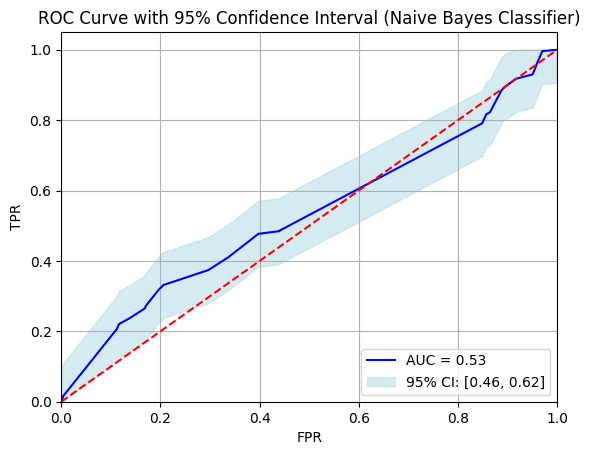

In [40]:
#===============================ROC Curve for Naive Bayes===============================================
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

std_err = np.std(tpr)/np.sqrt(len(tpr))

# Confidence interval
confidence_level = 0.95
z_score = 1.96  # Z socre for 95% confidence interval
upper_bound = np.minimum(tpr + std_err * z_score,1)
lower_bound = np.maximum(tpr - std_err * z_score,0)
# Plot the ROC curve with confidence interval
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,
                 label=f'95% CI: [{lower_bound.mean():.2f}, {upper_bound.mean():.2f}]')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with 95% Confidence Interval (Naive Bayes Classifier)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
#================================================================================================================

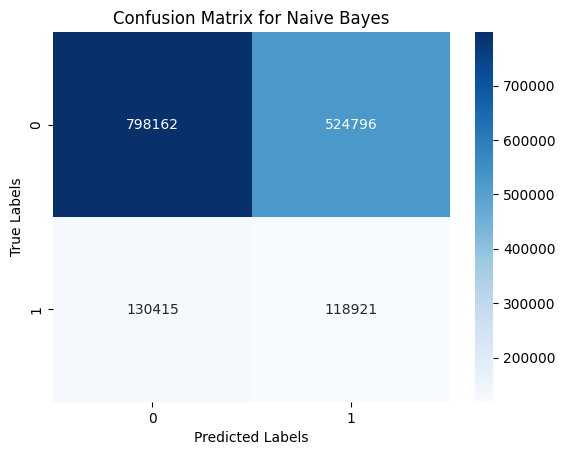

In [41]:
#===========================Confusion Matrix with Naive Bayes===========================
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()
#==============================================================================================

## Gradient Boosting Classifier

In [42]:
#=================================Gradient Boosting Model after applying SMOTE======================
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
gbm.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_gbm = gbm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_gbm)
print("Accuracy Score(Gradient Boosting Model):", accuracy)
#=====================================================================================================

Accuracy Score(Gradient Boosting Model): 0.7181843853630427


In [43]:
#================================================Hyperparameter Tuning of Gradient Boosting==========================================
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}
# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='accuracy')
mod = grid_search.fit(X_train_smote, y_train_smote)
best_params = grid_search.best_params_
#================================================================================================================

In [44]:
#===============================Gradient Boosting Model after applying Hyper parameter Tuning============================
gbm = GradientBoostingClassifier(n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'], subsample= best_params['subsample'])
gbm.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_gbm = gbm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_gbm)
accuracies.append(['Gradient Boosting Classifier', accuracy])
print("Accuracy Score(Gradient Boosting Model):", accuracy)
#=======================================================================================================================

Accuracy Score(Gradient Boosting Model): 0.7181799332694776


In [45]:
#=======================Gradient Boosting Classification Report===========================
report_gbm = classification_report(y_test, y_pred_gbm)
print(report_gbm)
#=========================================================================================

              precision    recall  f1-score   support

           0       0.88      0.77      0.82   1322958
           1       0.27      0.47      0.34    249336

    accuracy                           0.72   1572294
   macro avg       0.58      0.62      0.58   1572294
weighted avg       0.79      0.72      0.74   1572294



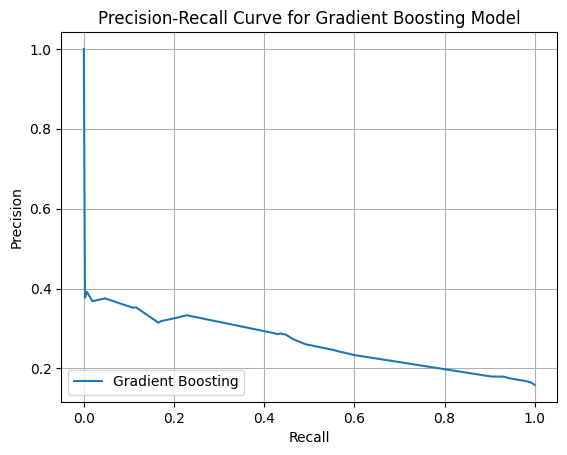

In [46]:
#================================PR ROC Curve for Gradient Boosting Model======================
y_pred_proba = gbm.predict_proba(X_test)[:, 1]
precision_dt ,recall_dt, thresholds_dt = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_dt, precision_dt, label='Gradient Boosting')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Gradient Boosting Model')
plt.legend(loc='lower left')
plt.grid()
plt.show()
#==============================================================================================

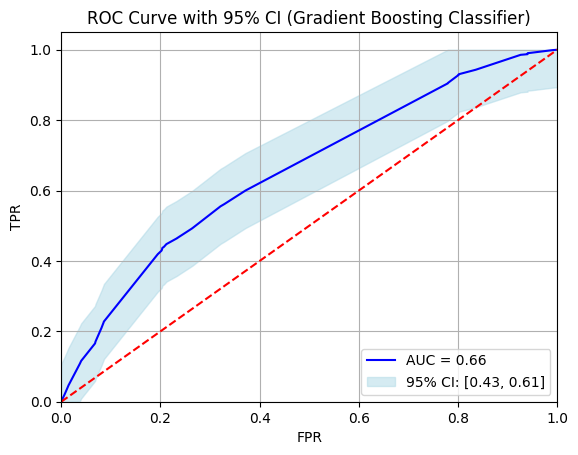

In [47]:
#===============================ROC Curve for Gradient Boosting===============================================
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

std_err = np.std(tpr)/np.sqrt(len(tpr))

# Confidence interval
confidence_level = 0.95
z_score = 1.96  # Z socre for 95% confidence interval
upper_bound = np.minimum(tpr + std_err * z_score,1)
lower_bound = np.maximum(tpr - std_err * z_score,0)
# Plot the ROC curve with confidence interval
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,
                 label=f'95% CI: [{lower_bound.mean():.2f}, {upper_bound.mean():.2f}]')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with 95% CI (Gradient Boosting Classifier)')
plt.legend(loc="lower right")
plt.grid()
plt.show()
#================================================================================================================

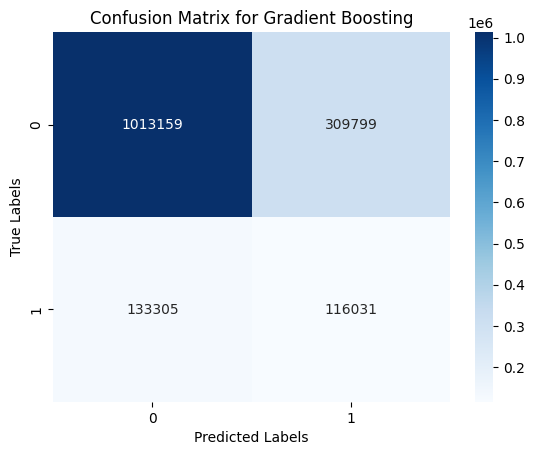

In [48]:
#===========================Confusion Matrix with Gradient Boosting===========================
cm = confusion_matrix(y_test, y_pred_gbm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Gradient Boosting')
plt.show()
#==============================================================================================

## Logistic Regression

In [49]:
#===============================Logistic Regression after applying SMOTE===================================
clf_LR = LogisticRegression(max_iter = 10000)

# Fitting the classifier to the training data
clf_LR.fit(X_train_smote, y_train_smote)

# Making predictions on the testing data
y_pred_LR = clf_LR.predict(X_test)

# Evaluating the accuracy of the model
accuracy_LR = accuracy_score(y_test, y_pred_LR)
accuracies.append(['Logistic Regression', accuracy_LR])
print("Accuracy:", accuracy_LR)
#=========================================================================================================

Accuracy: 0.6107986165437252


In [50]:
#============================Hyper-parameter tuning for Logistic Regression==============================
param_grid = { 'C': [0.001, 0.01, 0.1, 1, 10, 100],'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid_search = GridSearchCV(clf_LR, param_grid, cv=5, verbose=0 ,scoring='accuracy')
grid_search.fit(X_train_smote, y_train_smote)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")
#=======================================================================================================

Best hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


In [51]:
#===============================Logistic Regression Model after applying Hyper parameter Tuning============================
clf_LR = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver = best_params['solver'])

# Fitting the classifier to the training data
clf_LR.fit(X_train_smote, y_train_smote)

# Making predictions on the testing data
y_pred_LR = clf_LR.predict(X_test)

# Evaluating the accuracy of the model
accuracy_LR = accuracy_score(y_test, y_pred_LR)
print("Accuracy:", accuracy_LR)

Accuracy: 0.6107986165437252


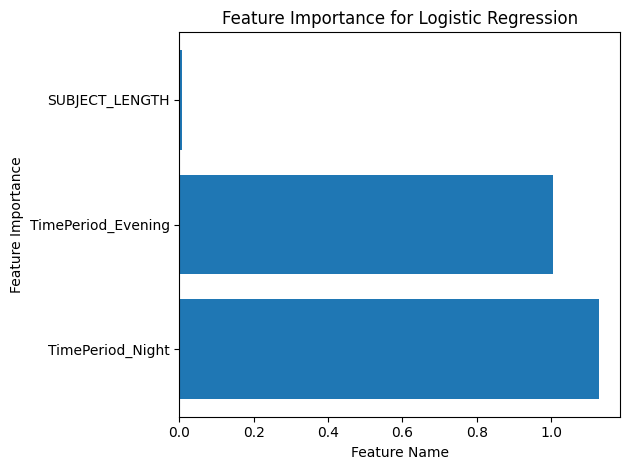

In [52]:
#======================Feature Importance based on Logistic Regression======================================
coefficients = clf_LR.coef_[0]

# Sort the coefficients by absolute value
sorted_coefficients = sorted(zip(X.columns, coefficients), key=lambda x: abs(x[1]), reverse=True)

# Create the feature importance graph
feature_names = [x[0] for x in sorted_coefficients]
feature_importances = [abs(x[1]) for x in sorted_coefficients]
plt.barh(feature_names,feature_importances)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for Logistic Regression')
plt.tight_layout()
plt.show()
#==========================================================================================================

In [53]:
#====================================Logistic Regression Classification Report===============
report_LR = classification_report(y_test, y_pred_LR)
print(report_LR)
#==============================================================================================

              precision    recall  f1-score   support

           0       0.86      0.64      0.74   1322958
           1       0.19      0.43      0.26    249336

    accuracy                           0.61   1572294
   macro avg       0.52      0.54      0.50   1572294
weighted avg       0.75      0.61      0.66   1572294



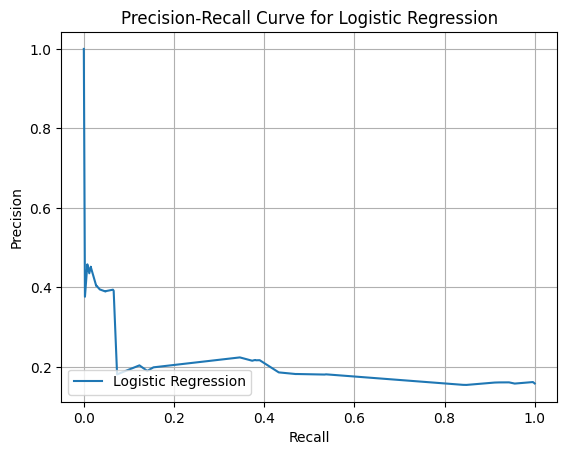

In [54]:
#==========================PR-ROC Curve Logistic Regression=========================
y_pred_prob = clf_LR.predict_proba(X_test)[:, 1]
precision_dt ,recall_dt, thresholds_dt = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall_dt, precision_dt, label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend(loc='lower left')
plt.grid()
plt.show()
#====================================================================================

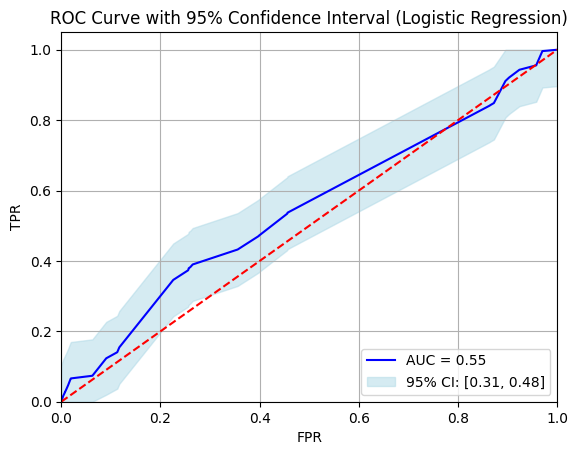

In [55]:
#==========================ROC Curve Logistic Regression==========================
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

std_err = np.std(tpr)/np.sqrt(len(tpr))

# Confidence interval
confidence_level = 0.95
z_score = 1.96  # Z socre for 95% confidence interval
upper_bound = np.minimum(tpr + std_err * z_score,1)
lower_bound = np.maximum(tpr - std_err * z_score,0)
# Plot the ROC curve with confidence interval
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,
                 label=f'95% CI: [{lower_bound.mean():.2f}, {upper_bound.mean():.2f}]')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with 95% Confidence Interval (Logistic Regression)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

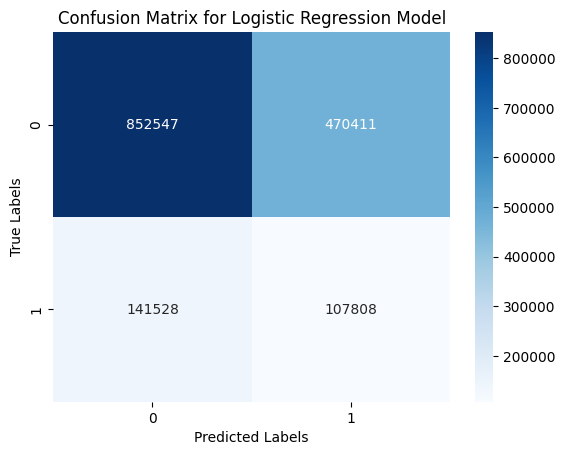

In [56]:
#==================================Confusion Matrix for Logistic Regression==================
cm = confusion_matrix(y_test, y_pred_LR)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()
#==============================================================================================

In [65]:
#=====================Creating dataFrame based on accuracies of model==========================
df =  pd.DataFrame(accuracies,columns=['Model','Accuracy'])
pd.options.mode.chained_assignment = None
df.sort_values(by=['Accuracy'],inplace=True,ascending=False)

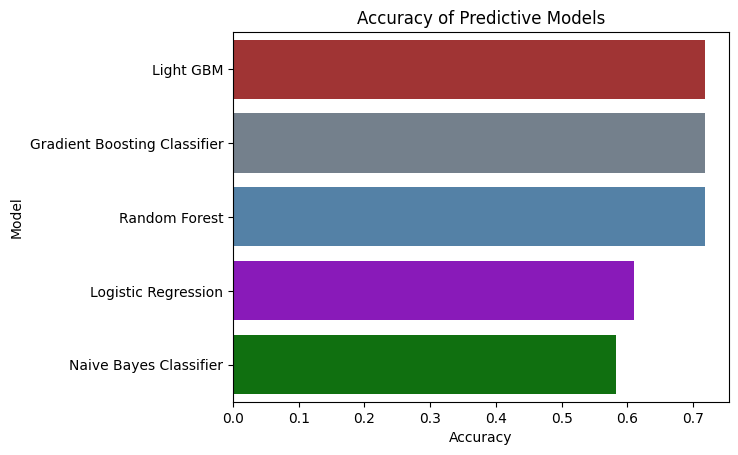

In [66]:
palette=['firebrick','slategray','steelblue', 'darkviolet', 'green']
sns.barplot(data=df, x='Accuracy', y='Model', hue='Model', palette=palette)
plt.title('Accuracy of Predictive Models')
plt.show()